In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from test_2D_diff_inferning import *

C:\Users\remra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
X_train, Y_train, XT_test, YT_test = getData()

input_image = tf.keras.layers.Input(shape=SIZE)
encoder0_pool, encoder0 = encoder_block(input_image, 16)
center = conv_block(encoder0_pool, 32)
decoder0 = decoder_block(center, encoder0, 16)
out = tf.keras.layers.Conv2D(2, (1,1))(decoder0)

model = tf.keras.Model(inputs=input_image, outputs=out)
model.load_weights('03-15/'+ '2D_diff_0.05_80_0.1417020933977456.h5')

Training set
(30, 24, 24, 3)
(30, 24, 24, 1)
Testing set
(30, 24, 24, 3)
(30, 24, 24, 1)


In [5]:
affinities = []
segmentations = []
for i in range(Y_train.shape[0]):
    XT = np.expand_dims(XT_test[i,:], axis=0)
    YT = np.expand_dims(YT_test[i,:], axis=0)
    YPT = model(XT)
    v_pred_img = rand_image(YPT[0])
    affinities.append(YPT[0].numpy())
    segmentations.append(v_pred_img)

In [6]:
print(np.array(affinities).shape)
print(np.array(segmentations).shape)

(30, 24, 24, 2)
(30, 24, 24)


In [7]:
from scipy import stats

In [8]:
stats.describe(np.array(affinities).flatten())

DescribeResult(nobs=34560, minmax=(-7.601698, 9.236231), mean=1.5824494, variance=4.4477367, skewness=-0.6923016905784607, kurtosis=0.32689906972524785)

In [9]:
import matplotlib.pyplot as plt

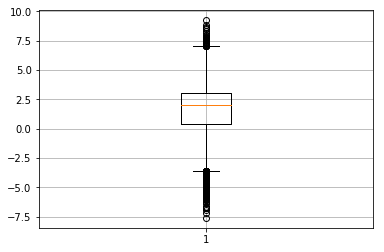

In [10]:
plt.boxplot(np.array(affinities).flatten())
plt.grid(True)

In [11]:
input_image = tf.keras.layers.Input(shape=SIZE)
encoder0_pool, encoder0 = encoder_block(input_image, 16)
center = conv_block(encoder0_pool, 32)
decoder0 = decoder_block(center, encoder0, 16)
out = tf.keras.layers.Conv2D(2, (1,1))(decoder0)

model2 = tf.keras.Model(inputs=input_image, outputs=out)
model2.load_weights('03-15/'+ '2D_diff_no_inference_0.05_50_0.18246135265700478.h5')

In [12]:
affinities2 = []
segmentations2 = []
for i in range(Y_train.shape[0]):
    XT = np.expand_dims(XT_test[i,:], axis=0)
    YT = np.expand_dims(YT_test[i,:], axis=0)
    YPT = model2(XT)
    v_pred_img = rand_image(YPT[0])
    affinities2.append(YPT[0].numpy())
    segmentations2.append(v_pred_img)

In [13]:
import pandas as pd

In [14]:
d = {'inferning':pd.Series(np.array(affinities).flatten()),
    'non_inferning':pd.Series(np.array(affinities2).flatten())}
df = pd.DataFrame(d)

Text(0,0.5,'Affinities')

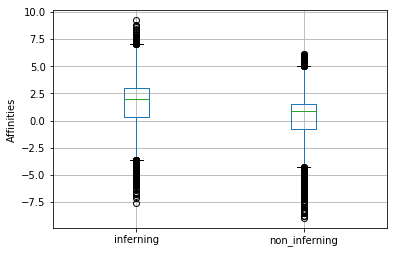

In [15]:
ax = df.boxplot(column=['inferning', 'non_inferning'])
ax.set_ylabel("Affinities")

In [16]:
import SegEval as ev

In [17]:
rocs_inferning = []
choices_inferning = []
lowTs = []
for i in range(Y_train.shape[0]):
    YP = affinities[i]
    Y = Y_train[i]
    G = nx.grid_2d_graph(SIZE[0], SIZE[1])
    nlabels_dict = dict()
    for u, v, d in G.edges(data = True):
        if u[0] == v[0]:
            channel = 0
        else:
            channel = 1
        d['weight'] =  YP[u[0], u[1], channel]
        nlabels_dict[u] = Y[u[0], u[1], 0]
        nlabels_dict[v] = Y[v[0], v[1], 0]
    (lowT, lowE, posCounts, negCounts, mstEdges, mstEdgeWeights, totalPos, totalNeg) = ev.FindMinEnergyAndRandCounts(G, nlabels_dict)
    #lowT, lowE, posCounts, negCounts, mstEdges, mstEdgeWeights, totalPos, totalNeg = ev.FindMinEnergyAndRandCounts(G, nlabels_dict)
    roc = []
    found = False
    [x,y] = (-1,-1)
    P = totalPos
    N = totalNeg
    localTP = 0.0
    localFP = 0.0
    roc.append([localTP/P, localFP/N])
    for i in range(len(mstEdgeWeights)):
        if (mstEdgeWeights[i]<lowT) and (not found):
            found = True
            [x,y] = roc[-1]
        localTP = localTP+posCounts[i]
        localFP = localFP+negCounts[i]
        #print(len(mstEdgeWeights))
        roc.append([localFP/N, localTP/P])
        #print([x,y])
    choices_inferning.append([x,y])
    rocs_inferning.append(roc)
rocs_inferning = np.array(rocs_inferning)
choices_inferning = np.array(choices_inferning)

In [18]:
rocs_inferning.shape

(30, 576, 2)

In [19]:
rocs_non_inferning = []
choices_non_inferning = []
for i in range(Y_train.shape[0]):
    YP = affinities2[i]
    Y = Y_train[i]
    G = nx.grid_2d_graph(SIZE[0], SIZE[1])
    nlabels_dict = dict()
    for u, v, d in G.edges(data = True):
        if u[0] == v[0]:
            channel = 0
        else:
            channel = 1
        d['weight'] =  YP[u[0], u[1], channel]
        nlabels_dict[u] = Y[u[0], u[1], 0]
        nlabels_dict[v] = Y[v[0], v[1], 0]
    (lowT, lowE, posCounts, negCounts, mstEdges, mstEdgeWeights, totalPos, totalNeg) = ev.FindMinEnergyAndRandCounts(G, nlabels_dict)
    roc = []
    found = False
    [x,y] = (-1,-1)
    P = totalPos
    N = totalNeg
    localTP = 0.0
    localFP = 0.0
    roc.append([localTP/P, localFP/N])
    for i in range(len(mstEdges)):
        if (mstEdgeWeights[i]<lowT) and (not found):
            found = True
            [x,y] = roc[-1]
        localTP = localTP+posCounts[i]
        localFP = localFP+negCounts[i]
        roc.append([localFP/N, localTP/P])
    choices_non_inferning.append([[x,y]])
    rocs_non_inferning.append(roc)
rocs_non_inferning = np.array(rocs_non_inferning)
choices_non_inferning = np.array(choices_non_inferning)

In [20]:
np.squeeze(choices_non_inferning)[:,0].shape

(30,)

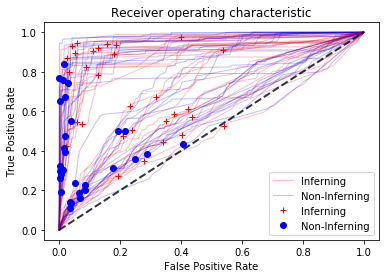

In [21]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
aucs = []
aucs1 = []
plt.figure()
for i in range(rocs_inferning.shape[0]):
    fpr = rocs_inferning[i,:,0]
    tpr = rocs_inferning[i,:,1]
    fpr1 = rocs_non_inferning[i,:,0]
    tpr1 = rocs_non_inferning[i,:,1]
    roc_auc = auc(fpr, tpr)
    roc_auc1 = auc(fpr1, tpr1)
    aucs.append(roc_auc)
    aucs1.append(roc_auc1)
    plt.plot(fpr, tpr, lw=1, alpha=0.25, color='r')
    plt.plot(fpr1, tpr1, lw=1, alpha=0.25, color='b')
    #plt.plot(tpr, 1-fpr, lw=1, alpha=0.25, color='r')
    #plt.plot(tpr1, 1-fpr1, lw=1, alpha=0.25, color='b')
plt.plot(fpr, tpr, lw=1, alpha=0.25, color='r', label='Inferning')
plt.plot(fpr1, tpr1, lw=1, alpha=0.25, color='b', label='Non-Inferning')
rocs = np.average(rocs_inferning, axis=0)
rocs1 = np.average(rocs_non_inferning, axis=0)
fpr = rocs[:,0]
tpr = rocs[:,1]
fpr1 = rocs1[:,0]
tpr1 = rocs1[:,1]
#plt.plot(fpr, tpr, linestyle='-', lw=2, alpha=0.7, color='r', label='Mean inferning ROC curve')
#plt.plot(fpr1, tpr1, linestyle='-', lw=2, alpha=0.7, color='b', label='Mean non inferning ROC curve')
#plt.plot(tpr, 1-fpr, linestyle='-', lw=2, alpha=0.7, color='r', label='Mean inferning ROC curve')
#plt.plot(tpr1, 1-fpr1, linestyle='-', lw=2, alpha=0.7, color='b', label='Mean non inferning ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)

plt.plot(np.squeeze(choices_inferning)[:,0], np.squeeze(choices_inferning)[:,1], 'r+', label='Inferning')
plt.plot(np.squeeze(choices_non_inferning)[:,0], np.squeeze(choices_non_inferning)[:,1], 'bo', label='Non-Inferning')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
rocs_inferning[:,0].shape

(30, 2)

In [23]:
num_cut_edge_inferning=[]
num_cut_edge_noninferning=[]
for i in range(Y_train.shape[0]):
    Y_inferning = affinities[i]
    Y_noninferning = affinities2[i]
    Y = Y_train[i]
    G = nx.grid_2d_graph(SIZE[0], SIZE[1])
    nlabels_dict = dict()
    for u, v, d in G.edges(data = True):
        if u[0] == v[0]:
            channel = 0
        else:
            channel = 1
        d['weight'] =  Y_inferning[u[0], u[1], channel]
    (lowT, lowE) = ev.FindMinEnergyThreshold(G)
    
    num_cut_edge_inferning.append((Y_inferning >= lowT).sum())
    num_cut_edge_noninferning.append((Y_noninferning >=0.0).sum())

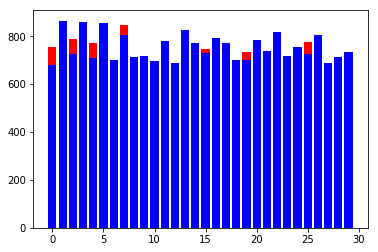

In [24]:
for i in range(len(num_cut_edge_inferning)):
    plt.bar(i, (num_cut_edge_inferning[i],num_cut_edge_noninferning[i]), color=['r','b'])
plt.show()

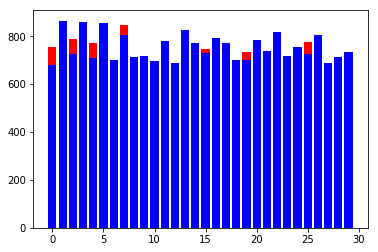

In [25]:
for i in range(len(num_cut_edge_inferning)):
    plt.bar(i, (num_cut_edge_inferning[i],num_cut_edge_noninferning[i]), color=['r','b'])
plt.show()

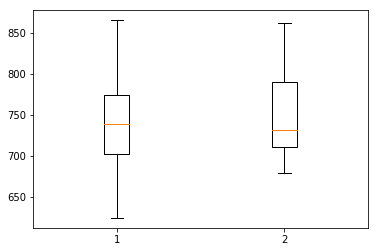

In [26]:
plt.boxplot([num_cut_edge_inferning,num_cut_edge_noninferning])
plt.show()